## 我们提取HOG特征向量后，就可以拿它作为分类器的输入了。


https://blog.csdn.net/qq_37781464/article/details/111604732

详解opencv的HOG描述子维度数目的计算原理

https://blog.csdn.net/ppp8300885/article/details/71078555

80行Python实现-HOG梯度特征提取

本文用80行代码的Python实现了HOG算法，虽然OpenCV有实现好的Hog描述器算法，但是本文目的是完全理解HOG特征提取的具体方法和实现原理，以及检验相关参数对实验结果的影响，提升检测到的特征的性能以及优化代码的运行速度。

1. 方法简介

**方向梯度直方图（Histogram of Oriented Gradient, HOG）特征**是一种在计算机视觉和图像处理中用来**进行物体检测的描述子**。通过计算和统计**局部区域的梯度方向直方图**来构成特征。Hog特征结合SVM分类器已经被广泛应用于图像识别中，尤其在行人检测中获得了极大的成功。现如今如今虽然有很多行人检测算法不断提出，但基本都是**以HOG+SVM的思路为主**。

主要思想：在一幅图像中，**局部目标的表象和形状**（appearance and shape）能够被梯度或边缘的方向密度分布很好地描述。**其本质是梯度的统计信息**，而梯度主要存在于边缘所在的地方。

实现过程：简单来说，**首先需要将图像分成小的连通区域，称之为细胞单元。然后采集细胞单元中各像素点的梯度或边缘的方向直方图。最后把这些直方图组合起来就可以构成特征描述器**。

算法优点：与其他的特征描述方法相比，HOG有较多优点。由于HOG是在图像的局部方格单元上操作，所以它对图像几何的和光学的形变都能保持很好的不变性，这两种形变只会出现在更大的空间领域上。其次，在粗的空域抽样、精细的方向抽样以及较强的局部光学归一化等条件下，只要行人大体上能够保持直立的姿势，可以容许行人有一些细微的肢体动作，这些细微的动作可以被忽略而不影响检测效果。因此HOG特征是特别适合于做图像中的人体检测的。

2. HOG流程

HOG特征提取算法的整个实现过程大致如下：

**读入所需要的检测目标即输入的image**

**将图像进行灰度化（将输入的彩色的图像的r,g,b值通过特定公式转换为灰度值）

**采用Gamma校正法对输入图像进行颜色空间的标准化（归一化）**

**计算图像每个像素的梯度（包括大小和方向），捕获轮廓信息**

**统计每个cell的梯度直方图（不同梯度的个数），形成每个cell的descriptor**

**将每几个cell组成一个block（以3×3为例），一个block内所有cell的特征串联起来得到该block的HOG特征descriptor**

**将图像image内所有block的HOG特征descriptor串联起来得到该image（检测目标）的HOG特征descriptor，这就是最终分类的特征向量**

**HOG参数设置是：2×2细胞／区间、8*8像素／细胞、8个直方图通道,步长为1。**

特征提取流程图如下:

**检测窗口——归一化图像——计算梯度——对每一个cell块对梯度直方图进行规定权重的投影——对每一个重叠block块内的cell进行对比度归一化**

**——把所有block内的直方图向量一起组合成一个大的HOG特征向量**

## 以下是比较细节的python代码，有助于我们更好地去理解HOG特征向量如何提取

## opencv 自带的函数请看最下面：

3. Python实现

3.1 数据准备

**读入彩色图像，并转换为灰度值图像, 获得图像的宽和高**。**采用Gamma校正法对输入图像进行颜色空间的标准化（归一化）**，目的是调节图像的对比度，降低图像局部的阴影和光照变化所造成的影响，同时可以抑制噪音。采用的gamma值为0.5。

In [2]:
#first part

import cv2
import numpy as np
img = cv2.imread('dujuan_1.jpg', cv2.IMREAD_GRAYSCALE)
# cv2.imshow('Image', img)
# cv2.imwrite("Image-test.jpg", img)
# cv2.waitKey(0)

img = np.sqrt(img / float(np.max(img)))
# cv2.imshow('Image', img)
# cv2.imwrite("Image-test2.jpg", img)
# cv2.waitKey(0)

3.2 计算每个像素的梯度

**计算图像横坐标和纵坐标方向的梯度，并据此计算每个像素位置的梯度方向值**；求导操作不仅能够捕获轮廓，人影和一些纹理信息，还能进一步弱化光照的影响。在求出**输入图像中像素点（x,y）处的水平方向梯度、垂直方向梯度和像素值，从而求出梯度幅值和方向**。

常用的方法是：首先用[-1,0,1]梯度算子对原图像做卷积运算，得到x方向（水平方向，以向右为正方向）的梯度分量gradscalx，然后用[1,0,-1]T梯度算子对原图像做卷积运算，得到y方向（竖直方向，以向上为正方向）的梯度分量gradscaly。然后再用以上公式计算该像素点的梯度大小和方向。

In [3]:
# second part

height, width = img.shape
gradient_values_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
gradient_values_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
gradient_magnitude = cv2.addWeighted(gradient_values_x, 0.5, gradient_values_y, 0.5, 0)
gradient_angle = cv2.phase(gradient_values_x, gradient_values_y, angleInDegrees=True)

print (gradient_magnitude.shape, gradient_angle.shape)

(3456, 4608) (3456, 4608)


3.3 为每个细胞单元构建梯度方向直方图

**我们将图像分成若干个“单元格cell”，默认我们将cell设为8×8个像素**。**假设我们采用8个bin的直方图来统计这8×8个像素的梯度信息**。也就是将cell的梯度方向360度分成8个方向块，例如：**如果这个像素的梯度方向是0-22.5度，直方图第1个bin的计数就加一**，这样，**对cell内每个像素用梯度方向在直方图中进行加权投影（映射到固定的角度范围），就可以得到这个cell的梯度方向直方图了**，就是该cell对应的8维特征向量而梯度大小作为投影的权值。

In [7]:
# third part

cell_size = 8
bin_size = 8
angle_unit = 360 / bin_size
gradient_magnitude = abs(gradient_magnitude)
cell_gradient_vector = np.zeros((int(height / cell_size), int(width / cell_size), bin_size))

print (cell_gradient_vector.shape)

def cell_gradient(cell_magnitude, cell_angle):
    orientation_centers = [0] * bin_size
    for k in range(cell_magnitude.shape[0]):
        for l in range(cell_magnitude.shape[1]):
            gradient_strength = cell_magnitude[k][l]
            gradient_angle = cell_angle[k][l]
            min_angle = int(gradient_angle / angle_unit)%8
            max_angle = (min_angle + 1) % bin_size
            mod = gradient_angle % angle_unit
            orientation_centers[min_angle] += (gradient_strength * (1 - (mod / angle_unit)))
            orientation_centers[max_angle] += (gradient_strength * (mod / angle_unit))
    return orientation_centers


for i in range(cell_gradient_vector.shape[0]):
    for j in range(cell_gradient_vector.shape[1]):
        cell_magnitude = gradient_magnitude[i * cell_size:(i + 1) * cell_size,
                         j * cell_size:(j + 1) * cell_size]
        cell_angle = gradient_angle[i * cell_size:(i + 1) * cell_size,
                     j * cell_size:(j + 1) * cell_size]
        #print (cell_angle.max())

        cell_gradient_vector[i][j] = cell_gradient(cell_magnitude, cell_angle)

(432, 576, 8)


3.4 可视化Cell梯度直方图

**将得到的每个cell的梯度方向直方图绘出，得到特征图**

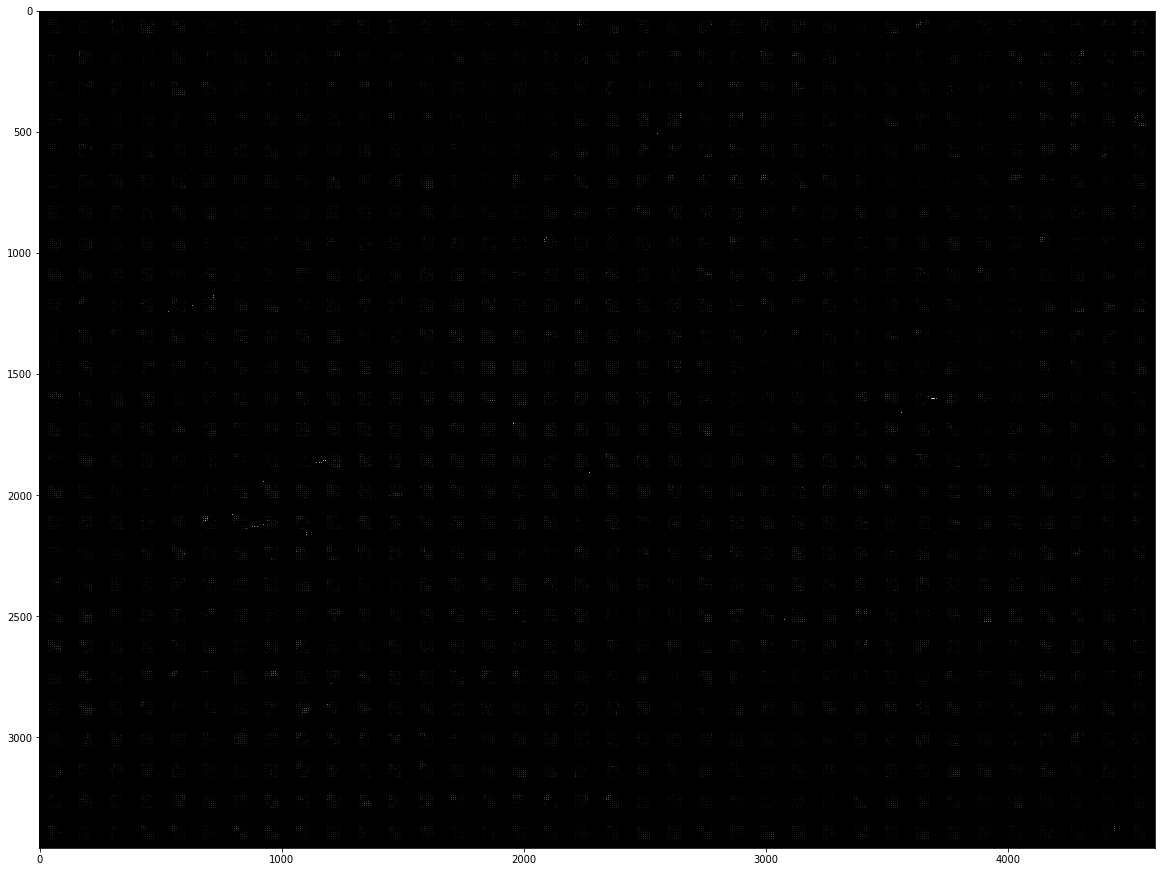

In [11]:
# fourth part

import math
import matplotlib.pyplot as plt

hog_image= np.zeros([height, width])
cell_gradient = cell_gradient_vector
cell_width = cell_size / 2
max_mag = np.array(cell_gradient).max()
for x in range(cell_gradient.shape[0]):
    for y in range(cell_gradient.shape[1]):
        cell_grad = cell_gradient[x][y]
        cell_grad /= max_mag
        angle = 0
        angle_gap = angle_unit
        for magnitude in cell_grad:
            angle_radian = math.radians(angle)
            x1 = int(x * cell_size + magnitude * cell_width * math.cos(angle_radian))
            y1 = int(y * cell_size + magnitude * cell_width * math.sin(angle_radian))
            x2 = int(x * cell_size - magnitude * cell_width * math.cos(angle_radian))
            y2 = int(y * cell_size - magnitude * cell_width * math.sin(angle_radian))
            cv2.line(hog_image, (y1, x1), (y2, x2), int(255 * math.sqrt(magnitude)))
            angle += angle_gap

plt.rcParams['figure.figsize'] = (20.0, 16.0)
plt.imshow(hog_image, cmap=plt.cm.gray)
plt.show()

In [12]:
print(hog_image)

[[2. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:
print(sum(hog_image))

[7617.    0.    0. ...    0.    0.    0.]


In [18]:
print(sum(map(sum,hog_image)))

14815870.0


### 不是黑漆漆的一片哦，有内容的。

3.5 统计Block的梯度信息

**把细胞单元组合成大的块(block），块内归一化梯度直方图**

由于局部光照的变化以及前景-背景对比度的变化，使得梯度强度的变化范围非常大。**这就需要对梯度强度做归一化**。归一化能够进一步地对光照、阴影和边缘进行压缩。

**把各个细胞单元组合成大的、空间上连通的区间（blocks）**。这样，**一个block内所有cell的特征向量串联起来便得到该block的HOG特征**。这些区间是互有重叠的，

本次实验采用的是矩阵形区间，它可以有三个参数来表征：**每个区间中细胞单元的数目、每个细胞单元中像素点的数目、每个细胞的直方图通道数目**。

本次实验中我们采用的参数设置是：**2×2细胞／区间、8×像素／细胞、8个直方图通道,步长为1。则一块的特征数为2×2×8。**

In [10]:
# fifth part
hog_vector = []
for i in range(cell_gradient_vector.shape[0] - 1):
    for j in range(cell_gradient_vector.shape[1] - 1):
        block_vector = []
        block_vector.extend(cell_gradient_vector[i][j])
        block_vector.extend(cell_gradient_vector[i][j + 1])
        block_vector.extend(cell_gradient_vector[i + 1][j])
        block_vector.extend(cell_gradient_vector[i + 1][j + 1])
        mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
        magnitude = mag(block_vector)
        if magnitude != 0:
            normalize = lambda block_vector, magnitude: [element / magnitude for element in block_vector]
            block_vector = normalize(block_vector, magnitude)
        hog_vector.append(block_vector)

print (np.array(hog_vector).shape)

(247825, 32)


#### 共有247825个block，每个block有32维的特征

此外在输入图像时，采用Gamma校正对输入图像进行颜色空间的标准化能够抑制噪声，使得产生的边缘更加明显，清晰。

此外改变cell的大小和直方图方向通道的效果如下：

cell_size = 10 即 16×16个像素

可以看出增大cell的size得到的特征图更加注重基本轮廓和边缘，而忽略一些细节，某种程度上降低了噪声。

当通道数目为16个方向
梯度特征图像的细节变得更加明显，方向更多。

**最后输出的就是原图的一种变换，有亮度的地方就是原图像素梯度变化最大的地方，如果最后的图跟预期一致，那么向量也就基本上正确，其实就是把这些向量可视化成了最后一张图**

**试着调节一下ksize，因为做过归一化处理，如果ksize太小，容易变全黑。**

**block_vector里面就是具体的block的特征向量**

In [20]:
print(block_vector)

[0.07595748118260712, 0.12225507844763617, 0.15005505177237327, 0.07063175396413236, 0.25018122908669577, 0.2108734349537669, 0.1679406067124382, 0.03315348010174668, 0.1154450334443998, 0.3892390115127539, 0.43149671219184005, 0.013079893861073721, 0.01700420810674715, 0.04664977373013537, 0.15067086840329882, 0.06503127568036263, 0.1970768678556056, 0.07436094902377163, 0.05339419483936947, 0.03624316786514191, 0.09257666559229959, 0.1404858228878817, 0.03911866658492116, 0.05628187224015077, 0.413763519751881, 0.35124355768070414, 0.2317988548562635, 0.02601804257769823, 0.030131328580201042, 0.0, 0.02525157385499298, 0.05256148657356709]


## 以下是Open Cv 自带的函数：

In [ ]:
from skimage import feature, exposure
from matplotlib import pyplot as plt
import cv2
image = cv2.imread('dujuan_1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

fd, hog_image = feature.hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 4), visualize=True)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

cv2.namedWindow("img",cv2.WINDOW_NORMAL)
cv2.imshow('img', image)
cv2.namedWindow("hog",cv2.WINDOW_NORMAL)
cv2.imshow('hog', hog_image_rescaled)
cv2.waitKey(0)==ord('q')

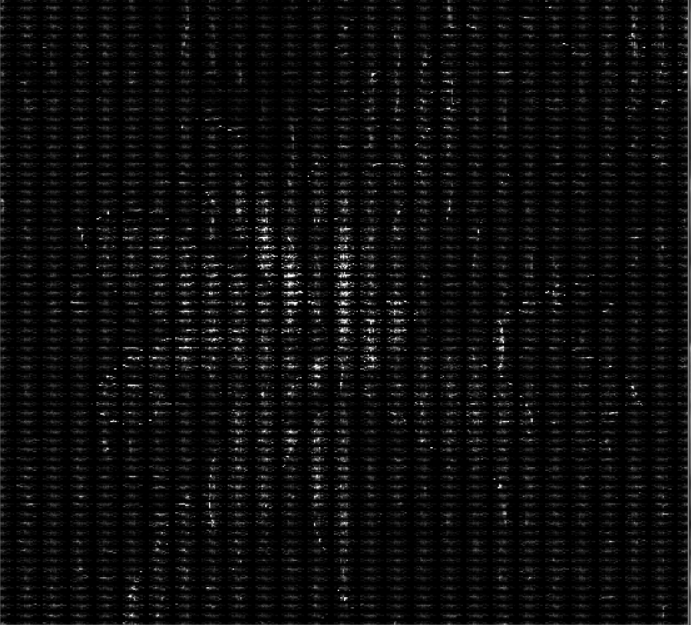

http://cn.voidcc.com/question/p-hligwznd-ng.html

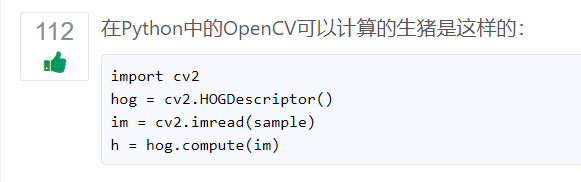

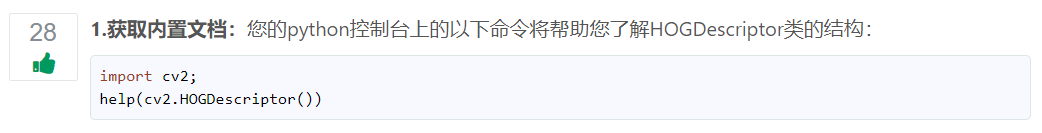

In [21]:
from matplotlib import pyplot as plt
import cv2
image = cv2.imread('dujuan_1.jpg',0)

winSize = (64,64) 
blockSize = (16,16) 
blockStride = (8,8) 
cellSize = (8,8) 
nbins = 9 
derivAperture = 1 
winSigma = 4. 
histogramNormType = 0 
L2HysThreshold = 2.0000000000000001e-01 
gammaCorrection = 0 
nlevels = 64 
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma, 
         histogramNormType,L2HysThreshold,gammaCorrection,nlevels) 
#compute(img[, winStride[, padding[, locations]]]) -> descriptors 
winStride = (8,8) 
padding = (8,8) 
locations = ((10,20),) 
hist = hog.compute(image,winStride,padding,locations) 
print(hist)


[[0.2879812 ]
 [0.16317321]
 [0.04977431]
 ...
 [0.09496932]
 [0.25137168]
 [0.25137168]]


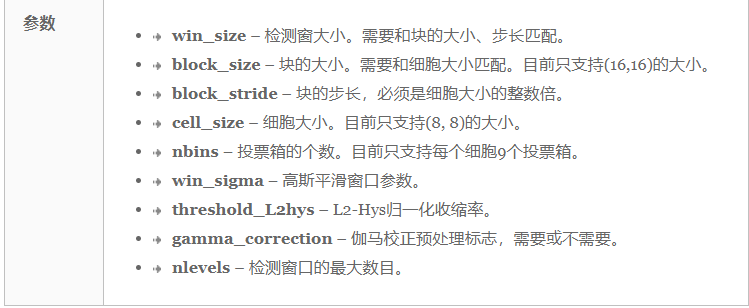

https://blog.csdn.net/wsp_1138886114/article/details/82964639

OpenCV—Python HOG方向梯度直方图 cv2.HOGDescriptor() 使用

numpy实现HOG算法

(247825, 32)


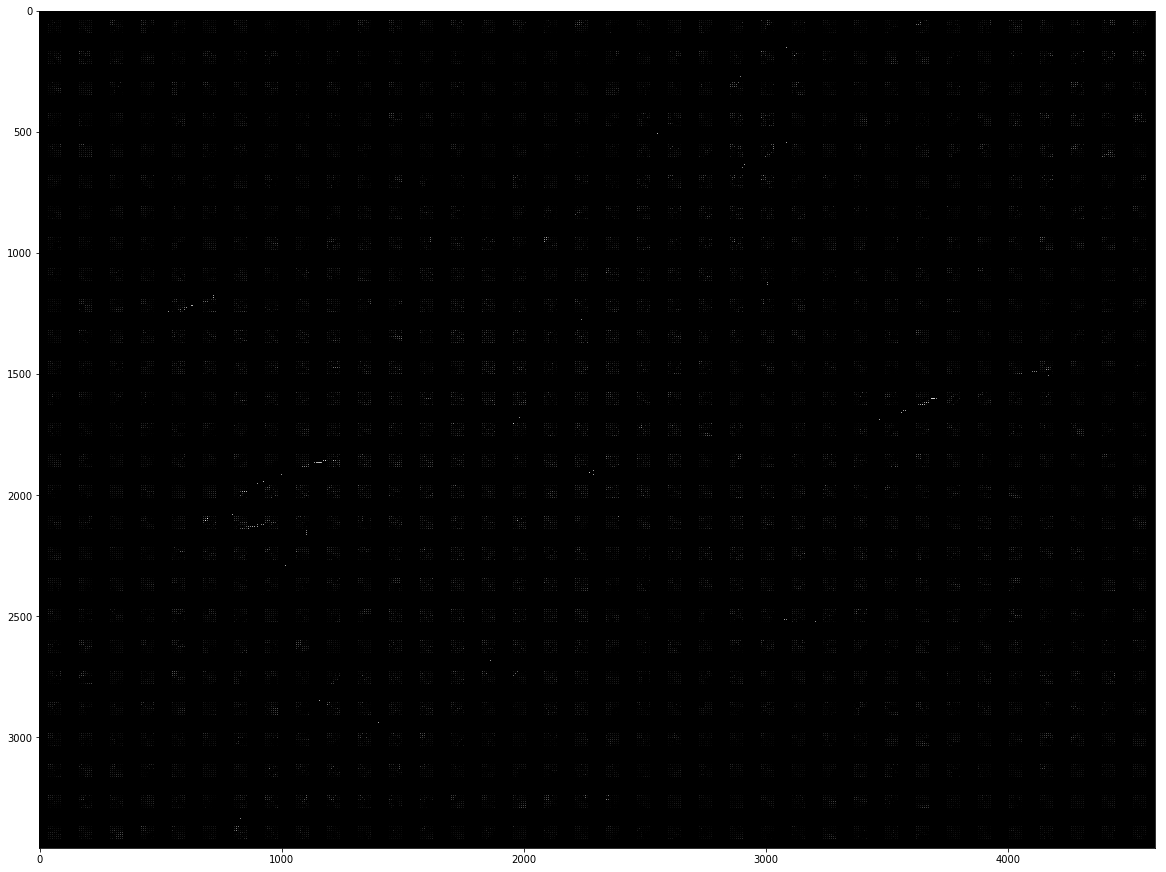

In [24]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt


class Hog_descriptor():
    def __init__(self, img, cell_size=16, bin_size=8):
        self.img = img
        self.img = np.sqrt(img / np.max(img))
        self.img = img * 255
        self.cell_size = cell_size
        self.bin_size = bin_size
        self.angle_unit = 360 // self.bin_size
        assert type(self.bin_size) == int,    "bin_size should be integer,"
        assert type(self.cell_size) == int,   "cell_size should be integer,"
        assert type(self.angle_unit) == int,  "bin_size should be divisible by 360"

    def extract(self):
        height, width = self.img.shape
        gradient_magnitude, gradient_angle = self.global_gradient()
        gradient_magnitude = abs(gradient_magnitude)

        cell_gradient_vector = np.zeros((height // self.cell_size, width // self.cell_size, self.bin_size))
        for i in range(cell_gradient_vector.shape[0]):
            for j in range(cell_gradient_vector.shape[1]):
                cell_magnitude = gradient_magnitude[i * self.cell_size:(i + 1) * self.cell_size,
                                 j * self.cell_size:(j + 1) * self.cell_size]
                cell_angle = gradient_angle[i * self.cell_size:(i + 1) * self.cell_size,
                             j * self.cell_size:(j + 1) * self.cell_size]
                cell_gradient_vector[i][j] = self.cell_gradient(cell_magnitude, cell_angle)

        hog_image = self.render_gradient(np.zeros([height, width]), cell_gradient_vector)

        hog_vector = []
        for i in range(cell_gradient_vector.shape[0] - 1):
            for j in range(cell_gradient_vector.shape[1] - 1):
                block_vector = []
                block_vector.extend(cell_gradient_vector[i][j])
                block_vector.extend(cell_gradient_vector[i][j + 1])
                block_vector.extend(cell_gradient_vector[i + 1][j])
                block_vector.extend(cell_gradient_vector[i + 1][j + 1])
                mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
                magnitude = mag(block_vector)
                if magnitude != 0:
                    normalize = lambda block_vector, magnitude: [element // magnitude for element in block_vector]
                    block_vector = normalize(block_vector, magnitude)
                hog_vector.append(block_vector)
        return hog_vector, hog_image

    def global_gradient(self):
        gradient_values_x = cv2.Sobel(self.img, cv2.CV_64F, 1, 0, ksize=5)
        gradient_values_y = cv2.Sobel(self.img, cv2.CV_64F, 0, 1, ksize=5)
        gradient_magnitude = cv2.addWeighted(gradient_values_x, 0.5, gradient_values_y, 0.5, 0)
        gradient_angle = cv2.phase(gradient_values_x, gradient_values_y, angleInDegrees=True)
        return gradient_magnitude, gradient_angle

    # 每个细胞单元构建梯度方向直方图
    def cell_gradient(self, cell_magnitude, cell_angle):
        orientation_centers = [0] * self.bin_size
        for i in range(cell_magnitude.shape[0]):
            for j in range(cell_magnitude.shape[1]):
                gradient_strength = cell_magnitude[i][j]
                gradient_angle = cell_angle[i][j]
                min_angle, max_angle, mod = self.get_closest_bins(gradient_angle)
                orientation_centers[min_angle] += (gradient_strength * (1 - (mod / self.angle_unit)))
                orientation_centers[max_angle] += (gradient_strength * (mod / self.angle_unit))
        return orientation_centers

    def get_closest_bins(self, gradient_angle):
        idx = int(gradient_angle / self.angle_unit)
        mod = gradient_angle % self.angle_unit
        return idx, (idx + 1) % self.bin_size, mod

    def render_gradient(self, image, cell_gradient):
        cell_width = self.cell_size / 2
        max_mag = np.array(cell_gradient).max()
        for x in range(cell_gradient.shape[0]):
            for y in range(cell_gradient.shape[1]):
                cell_grad = cell_gradient[x][y]
                cell_grad /= max_mag
                angle = 0
                angle_gap = self.angle_unit
                for magnitude in cell_grad:
                    angle_radian = math.radians(angle)
                    x1 = int(x * self.cell_size + magnitude * cell_width * math.cos(angle_radian))
                    y1 = int(y * self.cell_size + magnitude * cell_width * math.sin(angle_radian))
                    x2 = int(x * self.cell_size - magnitude * cell_width * math.cos(angle_radian))
                    y2 = int(y * self.cell_size - magnitude * cell_width * math.sin(angle_radian))
                    cv2.line(image, (y1, x1), (y2, x2), int(255 * math.sqrt(magnitude)))
                    angle += angle_gap
        return image

img = cv2.imread('dujuan_1.jpg', cv2.IMREAD_GRAYSCALE)
hog = Hog_descriptor(img, cell_size=8, bin_size=8)
vector, image = hog.extract()
print (np.array(vector).shape)
plt.imshow(image, cmap=plt.cm.gray)
plt.show()

直接调用

In [26]:
def createTrainingInstances(self, images):
    start = time.time()
    hog = cv2.HOGDescriptor()        # 初始化
    instances = []
    for img, label in images:
        img = read_color_image(img)   #函数未知
        img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
        descriptor = hog.compute(img)
        if descriptor is None:
            descriptor = []
        else:
            descriptor = descriptor.ravel()
        pairing = Instance(descriptor, label)
        instances.append(pairing)
    end = time.time() - start
    self.training_instances = instances
    print ("HOG TRAIN SERIAL: %d images -> %f" % (len(images), end))

计算HOG特征模块参数详情

In [27]:
def hog_compute(ims):
    samples=[]
    winSize = (64,64)
    blockSize = (16,16)
    blockStride = (8,8)
    cellSize = (8,8)
    nbins = 9
    derivAperture = 1
    winSigma = 4.
    histogramNormType = 0
    L2HysThreshold = 2.0000000000000001e-01
    gammaCorrection = 0
    nlevels = 64
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                            histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
    #compute(img[, winStride[, padding[, locations]]]) -> descriptors
    winStride = (8,8)
    padding = (8,8)
    locations = ((10,20),(30,30),(50,50),(70,70),(90,90),(110,110),(130,130),(150,150),(170,170),(190,190))
    for im in ims:
        hist = hog.compute(im,winStride,padding,locations)
        samples.append(hist)
    return np.float32(samples)

In [28]:
def compute_hog(image, locations):
    hog = cv2.HOGDescriptor()
    winStride = (8, 8)
    padding = (8, 8)
    hist = hog.compute(image, winStride, padding, locations)
    return hist 

https://blog.csdn.net/qq_36852276/article/details/94293375

基于python-opencv的HOG特征提取和使用cv2.HOGDescriptor()



本次模式识别课程要求实现路标检测，训练集只给了5个样本，测试集有50个样本，听说HOG特征+特征匹配就能达到很好的效果，因此采用了这种方法。

在python-opencv里，有定义了一个类cv2.HOGDescriptor，使用这个类就可以直接提取图片的HOG特征。

图片没有要求，3通道和单通道的我试一下结果一样。

网上关于这个类的介绍很少，翻了好多内容才找到了一部分。

首先来看一下如何直接使用构造函数来定义一个hog对象，下面就是定义的方法，里面的参数稍微看一下

（常用的就前面几个，后面的默认就行，在opencv教材里全部用的默认参数）



In [ ]:
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

常用的是winSize, blockSize, blockStride, cellSize, nbins这四个，

分别是窗口大小（单位：像素）、block大小（单位：像素）、block步长（单位：像素）、cell大小（单位：像素）、bin的取值

这些的概念建议找一个HOG教程自己看一下就行，我们用的时候就自己规定这几个参数就差不多了

（用默认的也可以，但是效果可能不好，毕竟这个特征描述子很看参数设置的，可以更换几组参数多试试）

贴一下我自己用的时候的过程：

In [1]:
import numpy as np
import cv2

img = cv2.imread("dujuan_1.jpg")

#在这里设置参数
winSize = (128,128)
blockSize = (64,64)
blockStride = (8,8)
cellSize = (16,16)
nbins = 9

#定义对象hog，同时输入定义的参数，剩下的默认即可
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

定义完HOG描述子对象hog之后，就能拿来计算图像的HOG特征了，

它封装的太好以至于用着非常简单无脑，直接用这个类中的成员函数compute就能求得一个图片的HOG特征描述子，

它的返回值一个拼接好的n×1维的特征向量

（应该就是把许多个特征向量横向拼接起来了，具体的n要看你设置的参数和窗口、block的步长），

数据结构是Numpy-nparray类型，利用numpy也非常方便处理，使用过程如下
compute常用的参数有3个，第一个是必须的参数，就是图片（用opencv读取的numpy-nparray，经测试3通道BGR或者单通道灰度图都可以，而且结果也一样）数据结构。第二个是winStride，是窗口滑动步长（影响最终n的大小）。第三个是padding，填充，就是在外面填充点来处理边界。
然后就开始使用compute来计算HOG特征描述子